## 목표:  Regression Problem을 pytorch로 해결

### Install Pytorch (For Google Colab)

In [ ]:
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)

     |████████████████████████████████| 591.8 MB 607 bytes/s 
     |████████████████████████████████| 19.1 MB 1.2 MB/s 
     |████████████████████████████████| 19.1 MB 1.2 MB/s 
     |████████████████████████████████| 21.0 MB 1.3 MB/s 
     |████████████████████████████████| 23.2 MB 1.3 MB/s 
     |████████████████████████████████| 23.3 MB 85.2 MB/s 
     |████████████████████████████████| 23.3 MB 85.2 MB/s 
     |████████████████████████████████| 22.1 MB 80.6 MB/s 
     |████████████████████████████████| 22.1 MB 122.8 MB/s 
     |████████████████████████████████| 17.4 MB 410 kB/s 
     |████████████████████████████████| 17.3 MB 79 kB/s 
     |████████████████████████████████| 12.8 MB 37.9 MB/s 
     |████████████████████████████████| 12.7 MB 75.9 MB/s 
     |████████████████████████████████| 11.8 MB 60.6 MB/s 
     |████████████████████████████████| 5.9 MB 43.2 MB/s 
     |████████████████████████████████| 6.6 MB 56.7 MB/s 
     |████████████████████████████████| 6.6 MB 55.2 MB/s 
   

### 1. Data Generation (Preparation)
Regression 실습에 사용할 데이터 준비(X가 2차원 Y가 1차원)  
아래 관계를 따르는 데이터 분포가 있으며 관측시 발생한 오차가 $e$가 더해져 있다고 가정  

```
# 코드로 형식 지정됨
```


$sin(x)$ 함수와 $log(x)$ 함수 모두 쉽게 생각할 수 있는 non-linear 함수

$$ e \sim \mathcal{N} (0, 0.5) $$
$$y = \ 2 sin(x_1) + log({1 \over 2}x_2^2) + e$$  


**Data Set**  
$$X_{train} \in \mathcal{R}^{1600 \times 2}, Y_{train} \in \mathcal{R}^{1600}$$  
$$X_{val} \in \mathcal{R}^{400 \times 2}, Y_{val} \in \mathcal{R}^{400}$$  
$$X_{test} \in \mathcal{R}^{400 \times 2}, Y_{test} \in \mathcal{R}^{400}$$

X, Y 데이터를 3D 공간에 시각화하기  
numpy의 random.rand() 함수를 사용하여 n개의 랜덤 샘플을 0~1의 uniform distribution에서 샘플링

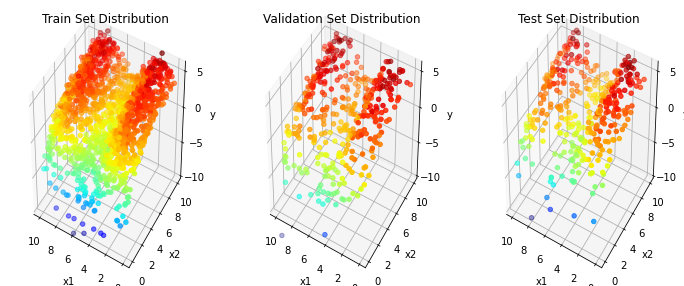

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# ====== Generating Dataset ====== #
num_data = 2400
x1 = np.random.rand(num_data) * 10
x2 = np.random.rand(num_data) * 10
e = np.random.normal(0, 0.5, num_data)
X = np.array([x1, x2]).T #T = transformation
y = 2*np.sin(x1) + np.log(0.5*x2**2) + e

# ====== Split Dataset into Train, Validation, Test ======#
train_X, train_y = X[:1600, :], y[:1600]
val_X, val_y = X[1600:2000, :], y[1600:2000]
test_X, test_y = X[2000:, :], y[2000:]

# ====== Visualize Each Dataset ====== #
fig = plt.figure(figsize=(12,5)) #여러개 그래프 만들 때 figure 만들어야함
ax1 = fig.add_subplot(1, 3, 1, projection='3d') #서브그래프들 생성 subplot(row, column, 칸)
ax1.scatter(train_X[:, 0], train_X[:, 1], train_y, c=train_y, cmap='jet')

ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y')
ax1.set_title('Train Set Distribution')
ax1.set_zlim(-10, 6) #z축의 범위
ax1.view_init(40, -60) #3d 보이는 각도 설정
ax1.invert_xaxis()

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(val_X[:, 0], val_X[:, 1], val_y, c=val_y, cmap='jet')

ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('y')
ax2.set_title('Validation Set Distribution')
ax2.set_zlim(-10, 6)
ax2.view_init(40, -60)
ax2.invert_xaxis()

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')

ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_zlabel('y')
ax3.set_title('Test Set Distribution')
ax3.set_zlim(-10, 6)
ax3.view_init(40, -60)
ax3.invert_xaxis()

plt.show()

### 2. Hypothesis Define (Model Define)  

Linear Regression 시에 활용하는 H(x) = Wx + b를 파이토치로 구현할 때는 단순하게 `nn.Linear` 모듈을 하나 만들어주면 됨  
이 때`in_features`는 x의 차원, `out_features`는 y의 차원 


**Linear Model**   
$$H = \ XW + b \ \ ( W \in \mathcal{R}^{2 \times 1}, b \in \mathcal{R}^{1}, H \in \mathcal{R}^{N \times 1})$$


**MLP Model**
$$Let \ relu(X) = \ max(X, 0)$$  

$$h = \ relu(X W_1 + b_1) \ \  ( W_1 \in \mathcal{R}^{2 \times 200}, b_1 \in \mathcal{R}^{200}, h \in \mathcal{R}^{N \times 200})$$  

$$H = \ h W_2 + b_2  \ \  ( W_2 \in \mathcal{R}^{200 \times 1}, b_2 \in \mathcal{R}^{1}, H \in \mathcal{R}^{N  \times 1})$$

In [ ]:
import torch
import torch.nn as nn


class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=1, bias=True)
    
    def forward(self, x):
    # 인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴합니다.
        return self.linear(x)
    
    
class MLPModel(nn.Module):
    def __init__(self): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
    # 인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴합니다.
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

### 3. Cost Function Define (Loss Function Define)  

Regression Problem 에서의 Loss Function을 작성   
파이토치의 `nn` 아래에는 다양한 Loss Function이 이미 구현되어 있음  
[여기](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html)에서 파이토치 내부에 구현되어 있는 MSE, Cross-Entropy, KL-Divergence 등을 확인 가능    
Mean Squared Error 즉 MSE Loss를 써봅시다.

In [ ]:
reg_loss = nn.MSELoss()

'''#uncomment for testing Loss Function
test_pred_y = torch.Tensor([0,0,0,0])
test_true_y = torch.Tensor([0,1,0,1])

print(reg_loss(test_pred_y, test_true_y))
print(reg_loss(test_true_y, test_true_y))'''

'#uncomment for testing Loss Function\ntest_pred_y = torch.Tensor([0,0,0,0])\ntest_true_y = torch.Tensor([0,1,0,1])\n\nprint(reg_loss(test_pred_y, test_true_y))\nprint(reg_loss(test_true_y, test_true_y))'

1. 반절 맞아서 0.5 나옴
2. 100% 예측했기 때문에 0이 나옴

### 4. Train & Evaluation

`pytorch`에서는 loss.backward() 라는 기능을 쓰면 알아서 loss를 계산되는데 사용한 각 파라미터에 대한 loss의 편미분을 계산    
이후 `optimizer.step()` 함수를 사용하면 각 파라미터의 그라디언트를 바탕으로 파라미터의 값을 조금씩 업데이트 해줌  

이 때 모델은 매 Iteration 때마다 Train Set에 의해 학습되면서 동시에 Validation Set을 넣고 Loss를 비교  
그리고 저희가 평가하고 싶은 때마다 (지금은 200번) Test Set을 넣고 Visualize 하는데 필요한 Predicted y값과 Metric 값을 계산(여기서 Metric으로는 mean absolute error(MAE)를 활용)

$$MAE(Y_{true}, Y_{predict}) = \sum_{i} | \ y_{true}^{(i)} - y_{predict}^{(i)} \ | $$

801 parameters


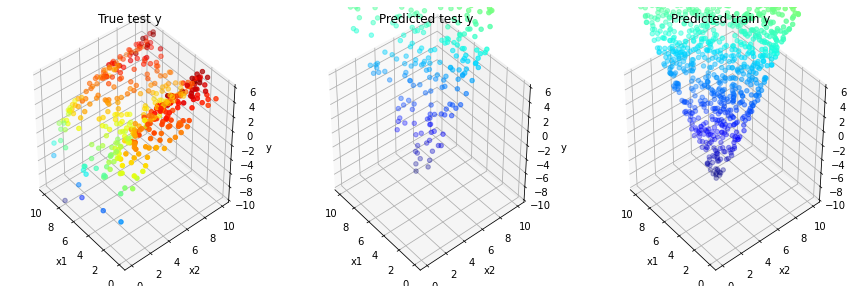

0 tensor(239.6105, grad_fn=<MseLossBackward>)


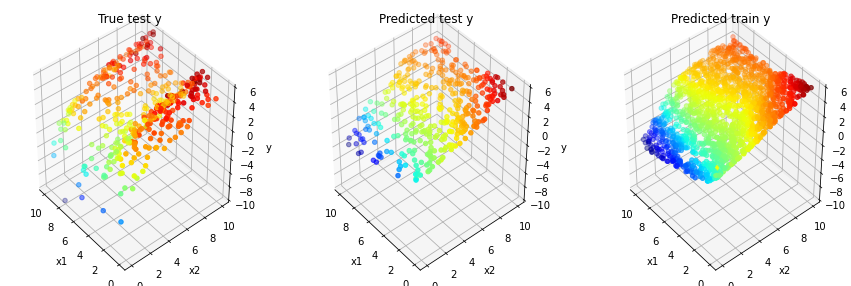

200 tensor(2.6298, grad_fn=<MseLossBackward>)


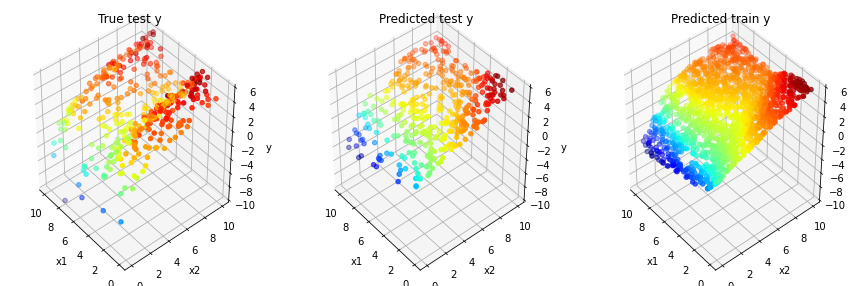

400 tensor(2.2408, grad_fn=<MseLossBackward>)


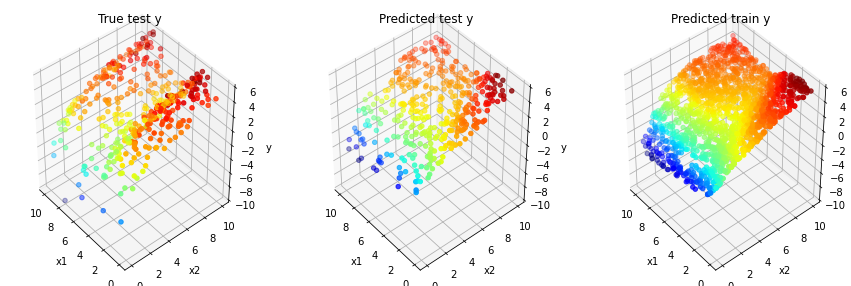

600 tensor(2.0038, grad_fn=<MseLossBackward>)


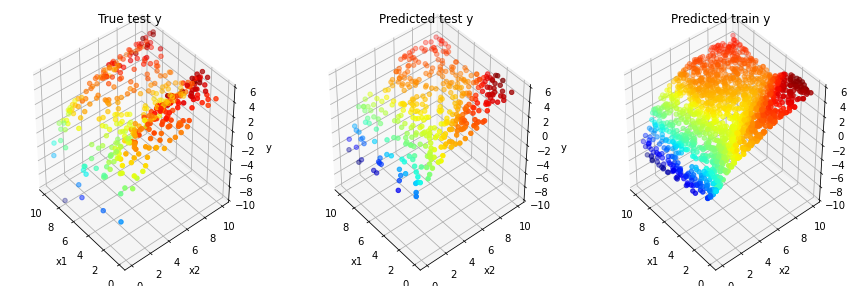

800 tensor(1.8507, grad_fn=<MseLossBackward>)


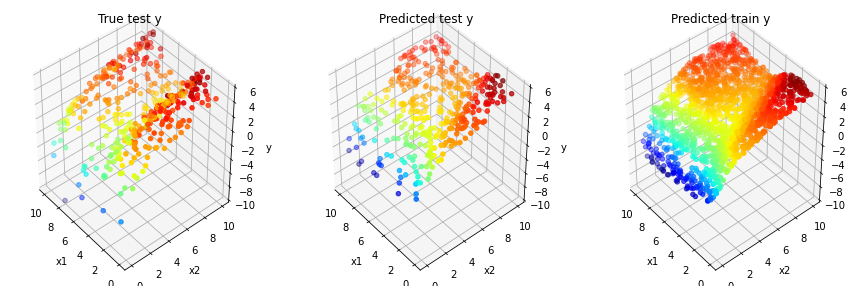

1000 tensor(1.7296, grad_fn=<MseLossBackward>)


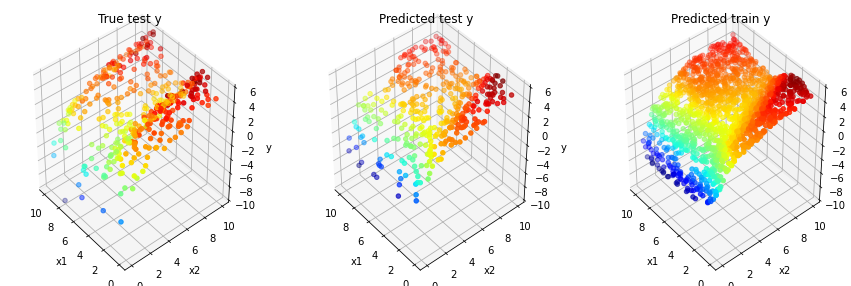

1200 tensor(1.6388, grad_fn=<MseLossBackward>)


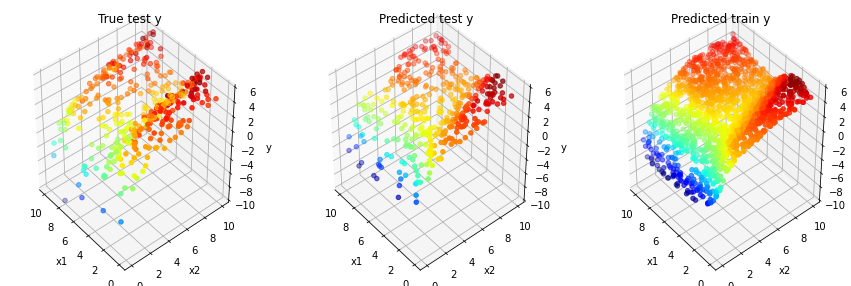

1400 tensor(1.5640, grad_fn=<MseLossBackward>)


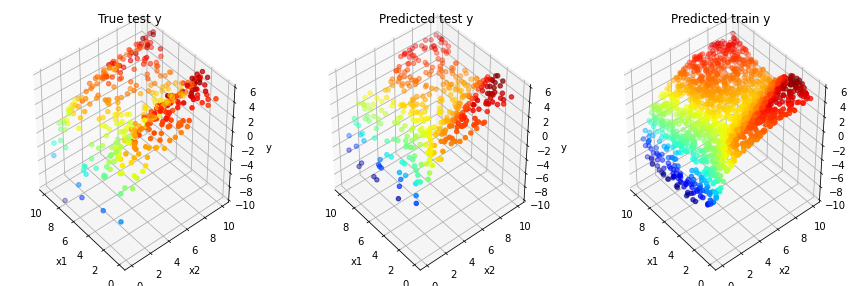

1600 tensor(1.5031, grad_fn=<MseLossBackward>)


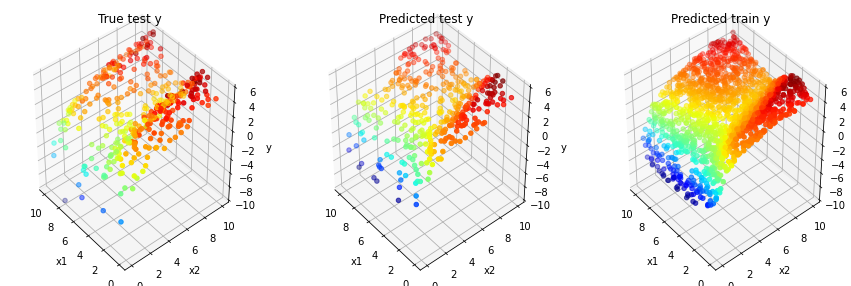

1800 tensor(1.4550, grad_fn=<MseLossBackward>)


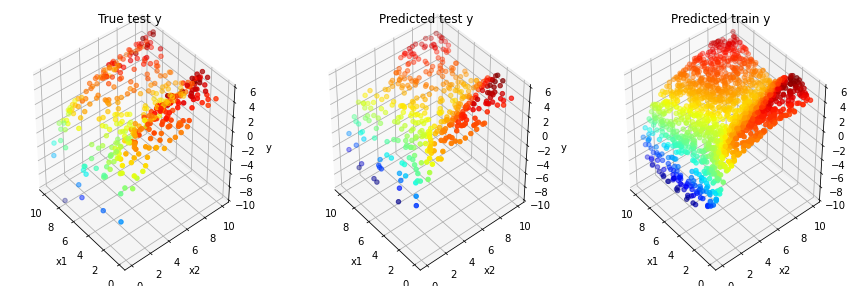

2000 tensor(1.4106, grad_fn=<MseLossBackward>)


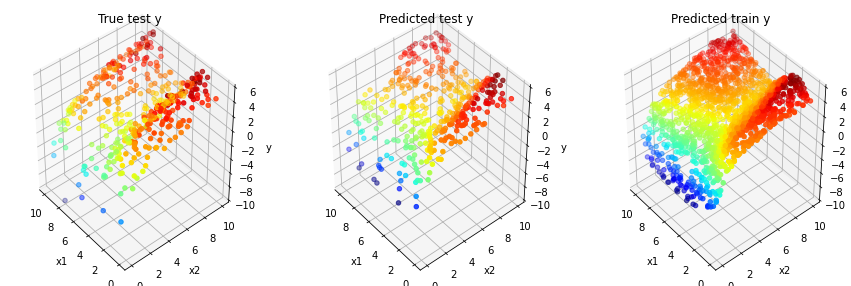

2200 tensor(1.3758, grad_fn=<MseLossBackward>)


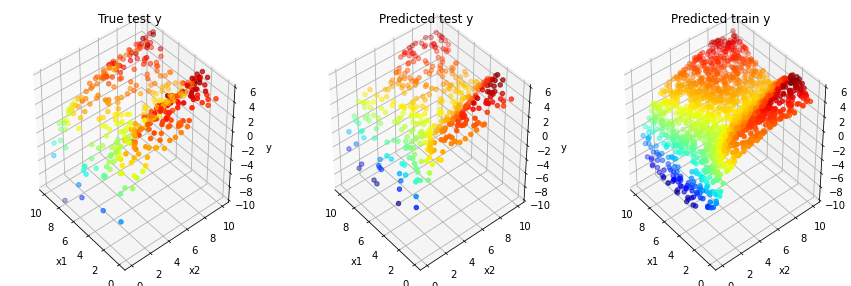

2400 tensor(1.3460, grad_fn=<MseLossBackward>)


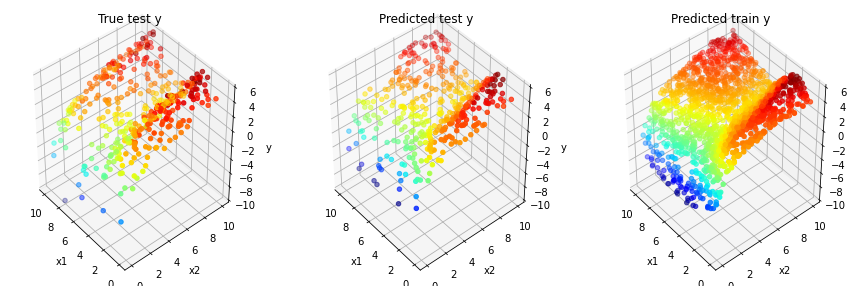

2600 tensor(1.3223, grad_fn=<MseLossBackward>)


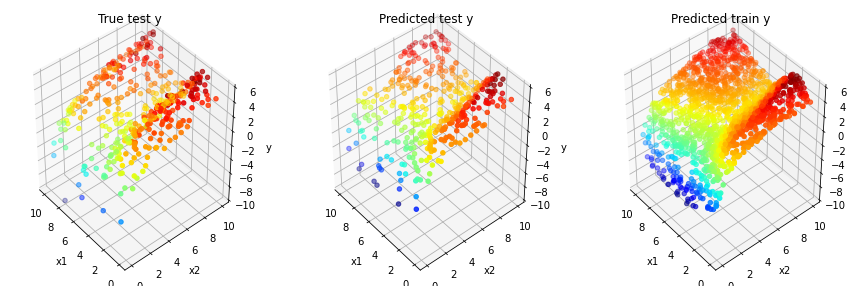

2800 tensor(1.3022, grad_fn=<MseLossBackward>)


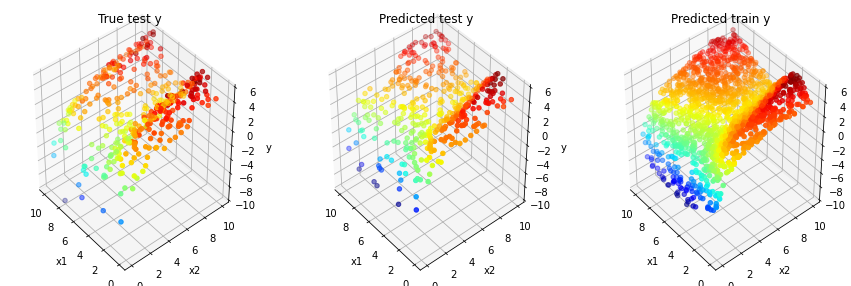

3000 tensor(1.2851, grad_fn=<MseLossBackward>)


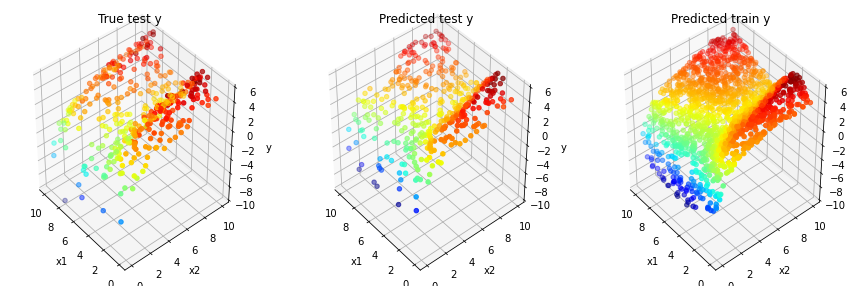

3200 tensor(1.2705, grad_fn=<MseLossBackward>)


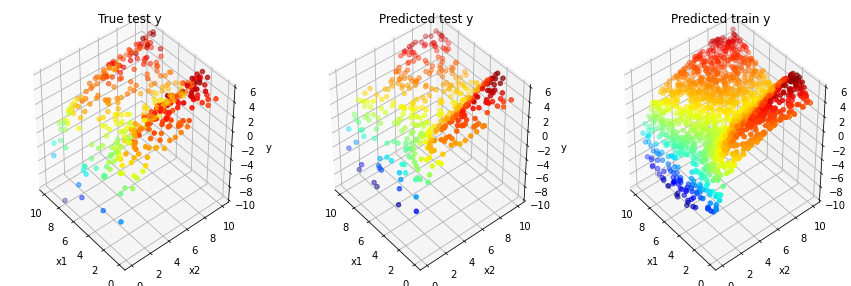

3400 tensor(1.2583, grad_fn=<MseLossBackward>)


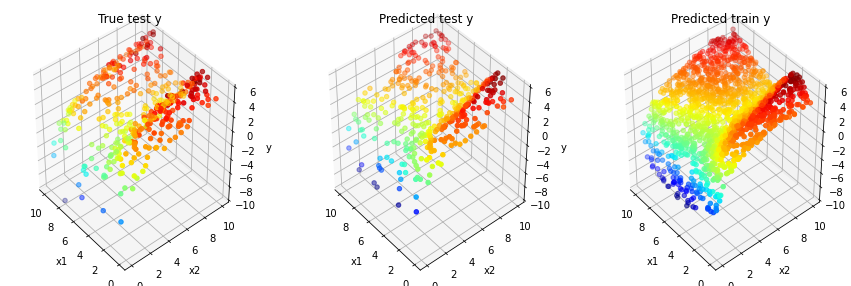

3600 tensor(1.2479, grad_fn=<MseLossBackward>)


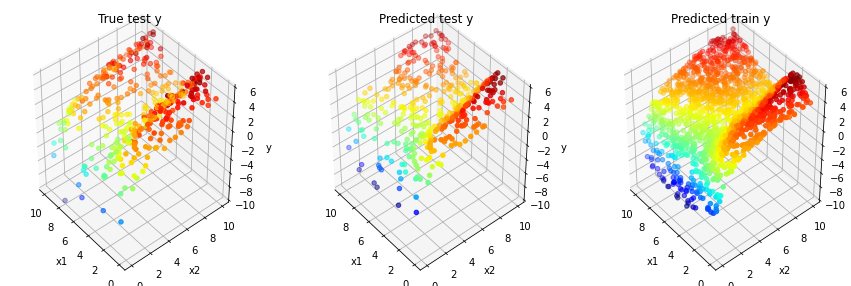

3800 tensor(1.2390, grad_fn=<MseLossBackward>)


In [ ]:
import torch.optim as optim
from sklearn.metrics import mean_absolute_error

# ====== Construct Model ====== #
# model = LinearModel()
# print(model.linear.weight)
# print(model.linear.bias)

model = MLPModel() #Model 생성
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))


# ===== Construct Optimizer ====== #
lr = 0.005 # Learning Rate를 하나 정해줍니다.
optimizer = optim.SGD(model.parameters(), lr=lr) # optimizer 생성

# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 저장할 리스트 생성
list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_mae = []
list_mae_epoch = []

epoch = 4000 #학습횟수 지정
for i in range(epoch):
    # ====== Train ====== #
    model.train() # model을 train 모드로 세팅
    optimizer.zero_grad() # optimizer에 남아있을 수도 있는 잔여 그라디언트를 0으로 다 초기화

    input_x = torch.Tensor(train_X)
    true_y = torch.Tensor(train_y)
    pred_y = model(input_x)
    #print(input_x.shape, true_y.shape, pred_y.shape) # 각 인풋과 아웃풋의 차원을 체크

    loss = reg_loss(pred_y.squeeze(), true_y) # 1을 날려줌
    loss.backward() #그라디언트 구함
    optimizer.step() #그라디언트 바탕으로 파라미터 업데이트
    list_epoch.append(i)
    list_train_loss.append(loss.detach().numpy())

    # ====== Validation ====== #
    model.eval()
    optimizer.zero_grad()
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y)
    pred_y = model(input_x)   
    loss = reg_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.detach().numpy()) #loss.item()

    # ====== Evaluation ======= #
    if i % 200 == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려보기

     # ====== Calculate MAE ====== #
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)
        pred_y = model(input_x).detach().numpy() 
        mae = mean_absolute_error(true_y, pred_y)
        list_mae.append(mae)
        list_mae_epoch.append(i)

        fig = plt.figure(figsize=(15,5))

        # ====== True Y Scattering ====== #
        ax1 = fig.add_subplot(1, 3, 1, projection='3d')
        ax1.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')
        
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_zlabel('y')
        ax1.set_zlim(-10, 6)
        ax1.view_init(40, -40)
        ax1.set_title('True test y')
        ax1.invert_xaxis()

         # ====== Predicted Y Scattering ====== #
        ax2 = fig.add_subplot(1, 3, 2, projection='3d')
        ax2.scatter(test_X[:, 0], test_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_zlabel('y')
        ax2.set_zlim(-10, 6)
        ax2.view_init(40, -40)
        ax2.set_title('Predicted test y')
        ax2.invert_xaxis()

        # ====== Just for Visualizaing with High Resolution ====== #
        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().numpy() 
        
        ax3 = fig.add_subplot(1, 3, 3, projection='3d')
        ax3.scatter(train_X[:, 0], train_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_zlabel('y')
        ax3.set_zlim(-10, 6)
        ax3.view_init(40, -40)
        ax3.set_title('Predicted train y')
        ax3.invert_xaxis()
        
        plt.show()
        print(i, loss)

### 5. Report Experiment  
학습 과정에서 기록했던 train_loss와 val_loss를 그려봅시다.   
Loss가 꾸준히 줄어드는지 확인하고 val_loss가 증가하기 시작다면 그 이상의 학습은 점점 모델의 성능을 망침을 뜻함 
그 옆에는 Epoch에 따라서 MAE metric이 얼마나 감소하는지 확인해봅시다.

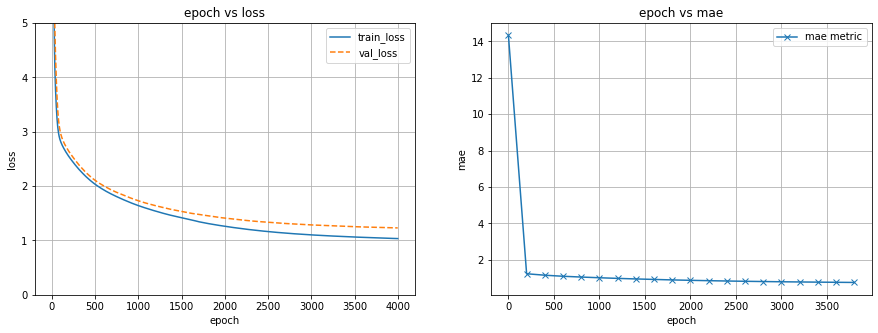

In [ ]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 5)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_mae_epoch, list_mae, marker='x', label='mae metric')

ax2.set_xlabel('epoch')
ax2.set_ylabel('mae')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs mae')


plt.show()